In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from gurobipy import*
from scipy.io import savemat,loadmat
import os 

In [2]:
np.random.seed(0)

In [3]:
from generate_instance import Update_Cols, generate_problem
from generate_models import Generate_CP_model, Generate_CP2_model

## Inserting parameters to generate instances

In [5]:
N_inst = 10

rmin = 0.1
rmax = 0.3
instance_sizes = [(10,30)]
square_size = 0.1

In [5]:
for i in range(N_inst):
    for (nodes,circles) in instance_sizes:
        p = circles
        Save_data = {"N_nodes":[0],"N_circles":[0],
                 "N_edges":[0],"N_constraints":[0],
                 "sol":[0],"OV":[0],"PRSF":[0],
                 "Matrix":[0],"Circles":[0],"max":[0],
                 "Ws":[0], "Nodes":[0], "R_min":[0],
                 "R_max":[0],"MIP_time":[0],"one_rows":[0]}


        t1 = time.time()
        A, edges, New_edges, circles_data, Ws, circles, Nodes, rmin, rmax, Nedges = generate_problem(nodes,circles,rmin,rmax)
        A, circle_data, New_edges, Ws, rmax = Update_Cols(A,circles_data,New_edges,Ws,rmin,rmax)
        t2 = time.time()
        print("Time generating instance: ",t2-t1)

        t1 = time.time()
        CP,x = Generate_CP_model(A,circles,Ws)
        CP.Params.LogToConsole = 0
        try: 
            os.makedirs( f"Logs/Inst_{nodes}_{p}_{i}", exist_ok = True) 
            os.makedirs( f"Instances/{nodes}_{p}_{i}", exist_ok = True)
        except OSError as error: 
            None
        CP.Params.LogFile = f"Logs/Inst_{nodes}_{p}_{i}/MIP"
        CP.optimize()
        Pres = CP.presolve()
        t2 = time.time()
        print("Time solving the CP problem: ",t2-t1)
        print("Presolve size:", len(Pres.getVars())," Original size:", p)

        Save_data["rmax"] = rmax
        Save_data["rmin"] = rmin
        Save_data["Nodes"] = Nodes
        Save_data["Ws"] = Ws
        Save_data["Matrix"] = A
        Save_data["Circles"] = circle_data
        Save_data["Edges"] = edges
        Save_data["PRSF"] = circles - len(Pres.getVars())
        Save_data["sol"] = x.X
        Save_data["OV"] = CP.ObjVal
        Save_data["max"] = circles-sum(x.X)
        Save_data["N_circles"] = circles
        Save_data["N_edges"] = Nedges
        Save_data["N_nodes"] = nodes
        Save_data["N_constraints"] = A.shape[0]
        Save_data["MIP_time"] = t2-t1
        Save_data["one_rows"] = len(np.where(np.array([sum(k) for k in A])==1)[0])

        t1 = time.time()
        CP2,x,y,z = Generate_CP2_model(Ws,circle_data,New_edges,square_size)
        CP2.Params.LogToConsole = 0
        CP2.Params.LogFile = f"Logs/Inst_{nodes}_{p}_{i}/Cont_p"
        CP2.setParam('TimeLimit', 3600*2)
        CP2.optimize()
        t2 = time.time()
        print("Time solving the CP2 problem: ",t2-t1)
        print("Diff CP2 to CP result:", CP.Objval - CP2.Objval)

        Save_data["new_centers"] = x.X
        Save_data["new_sol"] = z.X
        Save_data["y_aux"] = y.X
        Save_data["Time_Cont"] = t2-t1

        savemat(f"Instances/{nodes}_{p}_{i}/Data.mat", Save_data)
        print("="*50)

Number of problems generated:  3
Time generating instance:  0.1856372356414795
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 941647
Academic license 941647 - for non-commercial use only - registered to si___@cos.ufrj.br
Time solving the CP problem:  0.008883953094482422
Presolve size: 0  Original size: 30
Time solving the CP2 problem:  47.454195976257324
Diff CP2 to CP result: 0.1092351222313927
Number of problems generated:  1
Time generating instance:  0.1026151180267334
Time solving the CP problem:  0.0048863887786865234
Presolve size: 0  Original size: 30


/usr/local/lib/python3.10/dist-packages/scipy/io/matlab/_mio5.py:493: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  narr = np.asanyarray(source)


Time solving the CP2 problem:  43.43632888793945
Diff CP2 to CP result: 0.060937723366695895
Number of problems generated:  1
Time generating instance:  0.060632944107055664
Time solving the CP problem:  0.004374265670776367
Presolve size: 0  Original size: 30
Time solving the CP2 problem:  45.80318570137024
Diff CP2 to CP result: 0.1856395514642764
Number of problems generated:  1
Time generating instance:  0.08394336700439453
Time solving the CP problem:  0.004792690277099609
Presolve size: 4  Original size: 30
Time solving the CP2 problem:  37.25858688354492
Diff CP2 to CP result: 0.10437495573357294
Number of problems generated:  1
Time generating instance:  0.10334634780883789
Time solving the CP problem:  0.007100105285644531
Presolve size: 0  Original size: 30
Time solving the CP2 problem:  65.63656234741211
Diff CP2 to CP result: 0.06805311190646693
Number of problems generated:  1
Time generating instance:  0.07120370864868164
Time solving the CP problem:  0.004781961441040039

# Example

In [12]:
import matplotlib.patches as patches

In [9]:
Data = loadmat(f"Instances/10_30_0/Data.mat",squeeze_me=True)

Nodes = Data["Nodes"]
Circles = Data["Circles"]
new_centers = Data["new_centers"]
old_centers = np.array([k[1] for k in Circles])
Edges = Data["Edges"]
Edges = [(Nodes[p1],Nodes[p2]) for (p1,p2) in Edges]
Nodes = Data["Nodes"]
sol1 = Data["sol"]
Ws = Data["Ws"]
sol2 = Data["new_sol"]

Example of intance, the blue points are the center of the original CP problem and the squares represent the area for CP2:

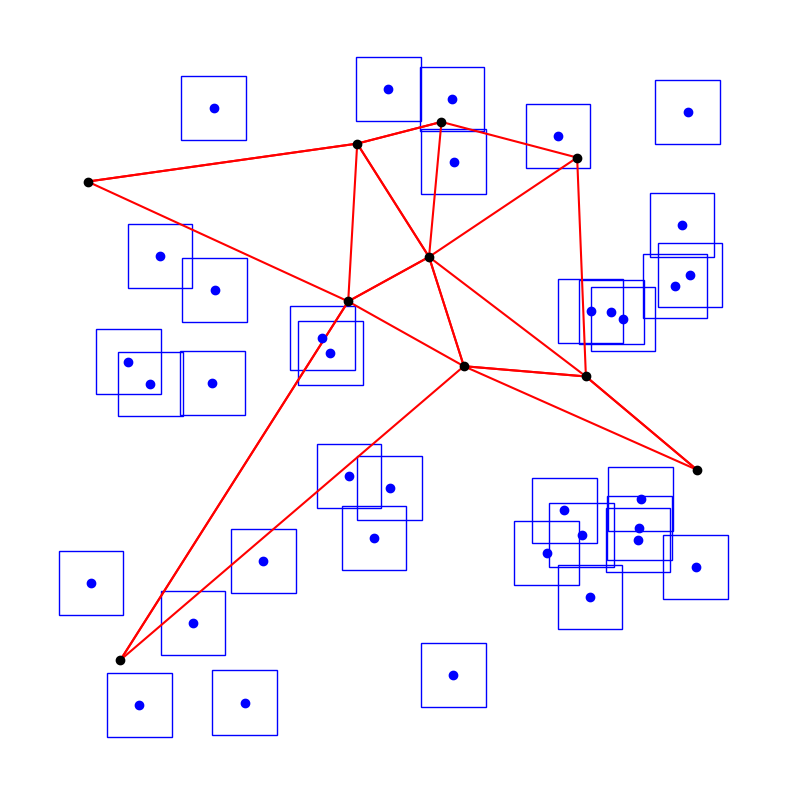

In [13]:
fig = plt.figure(figsize=(10,10))
        
for edge in Edges:
    xs = [i[0] for i in edge]
    ys = [i[1] for i in edge]
    plt.plot(xs,ys,"red")

ax = plt.gca()
for (a,b) in old_centers:
    #print(a,b)
    rect = patches.Rectangle((a-0.1/2, b-0.1/2), 0.1, 0.1, linewidth=1, edgecolor='blue', facecolor='none')
    ax.add_patch(rect)
circle = np.zeros(2)
for i in range(len(Circles)):
    circle[0] = Circles[i][1][0]
    circle[1] = Circles[i][1][1]
    R = Circles[i][0]
    ts = np.linspace(-np.pi,np.pi)
    xs = R*np.cos(ts)+circle[0]
    ys = R*np.sin(ts)+circle[1]
    #plt.plot(xs,ys,'green')
plt.plot(Nodes[:,0],Nodes[:,1],"o",color='black')
plt.plot(old_centers[:,0],old_centers[:,1],"o",color='blue')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])  
plt.axis('off')
plt.show()

## CP Instance

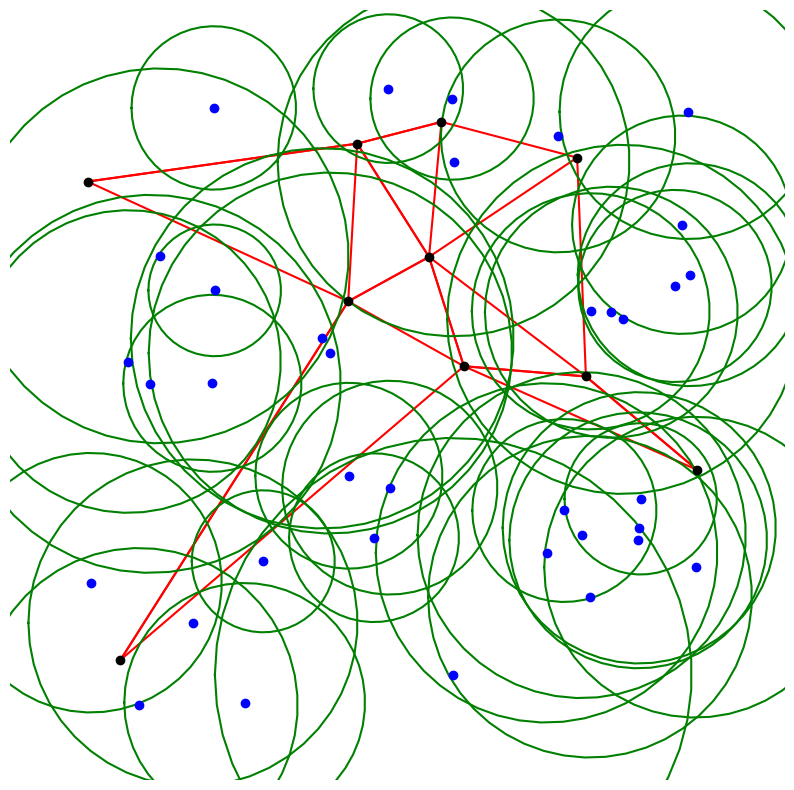

In [15]:
fig = plt.figure(figsize=(10,10))
        
for edge in Edges:
    xs = [i[0] for i in edge]
    ys = [i[1] for i in edge]
    plt.plot(xs,ys,"red")


circle = np.zeros(2)
for i in range(len(Circles)):
    circle[0] = Circles[i][1][0]
    circle[1] = Circles[i][1][1]
    R = Circles[i][0]
    ts = np.linspace(-np.pi,np.pi)
    xs = R*np.cos(ts)+circle[0]
    ys = R*np.sin(ts)+circle[1]
    plt.plot(xs,ys,'green')
plt.plot(Nodes[:,0],Nodes[:,1],"o",color='black')
plt.plot(old_centers[:,0],old_centers[:,1],"o",color='blue')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])  
plt.axis('off')
plt.show()

# CP Solution

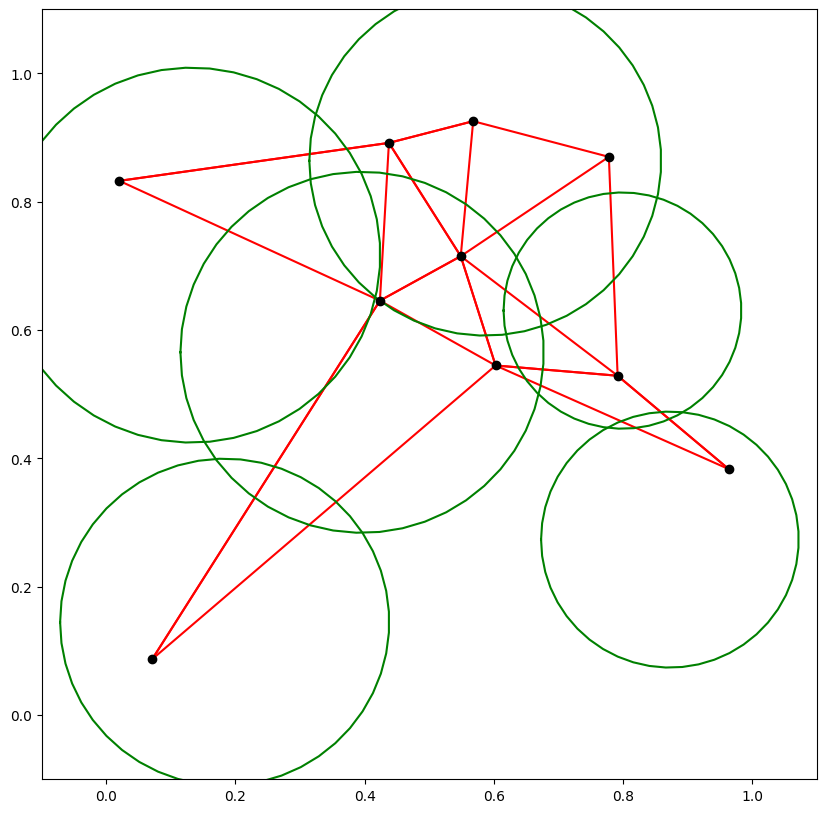

In [17]:
fig = plt.figure(figsize=(10,10))
        
for edge in Edges:
    xs = [i[0] for i in edge]
    ys = [i[1] for i in edge]
    plt.plot(xs,ys,"red")



circle = np.zeros(2)
for i in np.where(sol1==1)[0]:
    circle[0] = Circles[i][1][0]
    circle[1] = Circles[i][1][1]
    R = Circles[i][0]
    ts = np.linspace(-np.pi,np.pi)
    xs = R*np.cos(ts)+circle[0]
    ys = R*np.sin(ts)+circle[1]
    plt.plot(xs,ys,'green')
plt.plot(Nodes[:,0],Nodes[:,1],"o",color='black')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])  
plt.show()

## CP2 solution

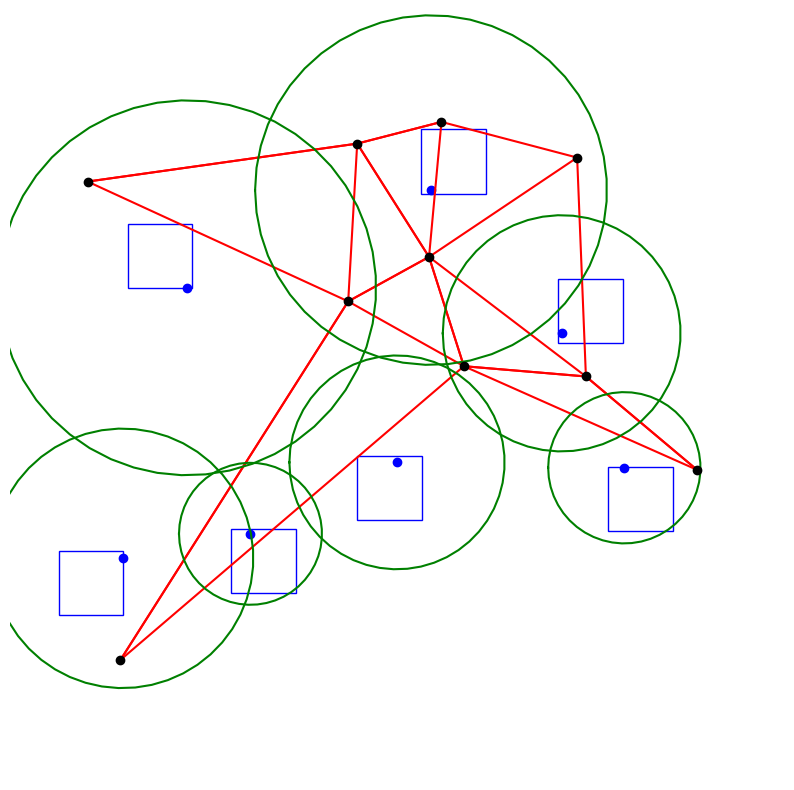

In [19]:
fig = plt.figure(figsize=(10,10))
        
for edge in Edges:
    xs = [i[0] for i in edge]
    ys = [i[1] for i in edge]
    plt.plot(xs,ys,"red")
ax = plt.gca()
for (a,b) in old_centers[np.where(sol2==1)[0]]:
    rect = patches.Rectangle((a-0.1/2, b-0.1/2), 0.1, 0.1, linewidth=1, edgecolor='blue', facecolor='none')
    ax.add_patch(rect)
circle = np.zeros(2)

circle = np.zeros(2)
for i in np.where(sol2==1)[0]:
    circle[0] = new_centers[i][0]
    circle[1] = new_centers[i][1]
    plt.scatter([circle[0]],[circle[1]],color="blue")
    R = Circles[i][0]
    ts = np.linspace(-np.pi,np.pi)
    xs = R*np.cos(ts)+circle[0]
    ys = R*np.sin(ts)+circle[1]
    plt.plot(xs,ys,'green')
plt.plot(Nodes[:,0],Nodes[:,1],"o",color='black')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])  
plt.axis('off')
plt.show()

## CP2 solution on original problem

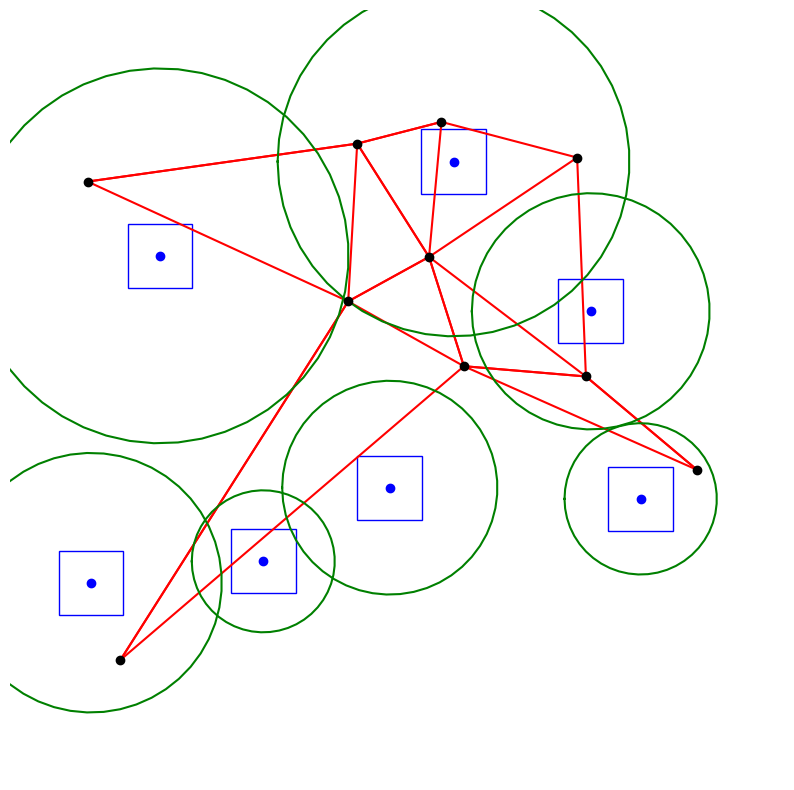

In [20]:
fig = plt.figure(figsize=(10,10))
        
for edge in Edges:
    xs = [i[0] for i in edge]
    ys = [i[1] for i in edge]
    plt.plot(xs,ys,"red")

ax = plt.gca()
for (a,b) in old_centers[np.where(sol2==1)[0]]:
    plt.scatter([a],[b],color="blue")
    rect = patches.Rectangle((a-0.1/2, b-0.1/2), 0.1, 0.1, linewidth=1, edgecolor='blue', facecolor='none')
    ax.add_patch(rect)
circle = np.zeros(2)
for i in np.where(sol2==1)[0]:
    circle[0] = Circles[i][1][0]
    circle[1] = Circles[i][1][1]
    R = Circles[i][0]
    ts = np.linspace(-np.pi,np.pi)
    xs = R*np.cos(ts)+circle[0]
    ys = R*np.sin(ts)+circle[1]
    plt.plot(xs,ys,'green')
plt.plot(Nodes[:,0],Nodes[:,1],"o",color='black')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])  
plt.axis('off')
plt.show()